# Applied Data Analysis

## Fall Semester 2016

Team members:
* Stylianos Agapiou (stylianos.agapiou@epfl.ch)
* Athanasios Giannakopoulos (athanasios.giannakopoulos@epfl.ch)
* Dimitrios Sarigiannis (dimitrios.sarigiannis@epfl.ch)

## Project Description

We are given a dataset containing tweets in Switzerland starting from 2010. 

The first goal of the project is to analyse the data and reconstruct mobility flows of the users. More concretely, we try to get insights into high-frequency migration patterns in the swiss territory. The implementation is given in [mobility_patterns](mobility_patterns.ipynb). We also perform data analysis on aggregated data from all years that have been processed in the [mobility_patterns_aggregated](mobility_patterns_aggregated.ipynb) notebook.

The second task of the project is to detect events. Here, we focus on dates and locations of such events. The implementation in given in [event_detection](event_detection.ipynb).

The third and final part of the project deals with sentiment analysis. Here, we focus on the tweets linked to events (as detected in the [event_detection](event_detection.ipynb) notebook) and perform a sentiment analysis for each event. The implementation of the sentiment analysis is given in the [sentiment_analysis](sentiment_analysis.ipynb) notebook.


## Mobility Patterns

This notebook focuses on the mobility pattern detection in Switzerland. Specifically, we perform the following tasks using the given dataset:

* we try to determine the home and workplace location for each user.
* given the home and workplace location, we estimate the average time and distance to go to work.
* we study mobility flows by finding how many users live and work in the same or in different cantons. For some years, the study reveals that there are a few users who do not live but work in Switzerland.
* finally, we study the radius of gyration for each user.

In order to analyse the mobility flows, several assumptions are taken into account. These assumptions are described in detail later in the report.

In [1]:
%matplotlib inline
from utils_mobility import *

### Data Loading

Since our dataset contains tweets from 2010 to 2016, we do a yearly based analysis. This approach gives us the following advantages:
* the yearly analysis reveals how people use Twitter as time evolves (e.g. social networks become more popular, so it is probable that people used Twitter more in 2013 compared to 2010).
* we can study the results in a yearly basis.
* if necessary, we have the ability to combine these results at the end and get results on the whole dataset (see [mobility_patterns_aggregated](mobility_patterns_aggregated.ipynb)).

In [2]:
# year to be analyzed
year = '2010'
# file name
file_name = '../../data/tweets_' + year + '.csv'
# loading data (treating NaN values and datetime format)
data = pd.read_csv(file_name, sep='|', na_values=['\\N'], header=None, parse_dates=[2])
# give columns proper names
data.columns = ['tweetId', 'userId', 'createdAt', 'longitude', 'latitude', 'placeLatitude', 'placeLongitude']
# display dataframe
data.head()

,tweetId,userId,createdAt,longitude,latitude,placeLatitude,placeLongitude
0,9514097914,17341045,2010-02-23 05:55:51,7.43926,46.9489,NaN,NaN
1,9514846412,7198282,2010-02-23 06:22:40,8.53781,47.3678,NaN,NaN
2,9516574359,14657884,2010-02-23 07:34:25,6.13396,46.1951,NaN,NaN
3,9516952605,14703863,2010-02-23 07:51:47,8.81749,47.2288,NaN,NaN
4,9517198943,14393717,2010-02-23 08:02:57,6.63254,46.5199,NaN,NaN


Twitter data should by analysed cautiously. Twitter users vary from inactive users (i.e. users who have accounts but do not tweet) to spammers (i.e. users who tweet very frequently without any particular reason). Therefore, a filtering is required, based on the user behaviour, so that noise is removed from the data.

In our case, we consider as noise, people who are inactive users. Our purpose is to study mobility flows, so we cannot include users that tweet infrequently, since their mobility pattern cannot be revealed. Moreover, following the methodology presented in [[1]](#refs), users that tweet quite often should also be removed. The *sweet spot* of users that should be kept for analysis is given below.

![Figure](../../data/figures/sweet_spot.png)

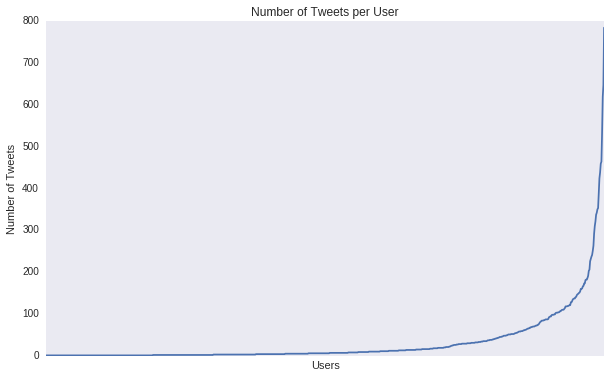

In [3]:
# find tweets per user
tweets_per_user = count_tweets_per_user(data)
# visualize distribution
visualize_tweets_per_user(tweets_per_user)

We wish to keep the *sweet spot* of the depicted curve. Therefore, we set a lower threshold, i.e. a minimum number of tweets per user per year, in order to filter out non active users. Also, we set an upper threshold, i.e. a maximum number of tweets per user per year, in order to filter out spammers.

In [4]:
# empricial thresholds for active users
lower_threshold = 100
upper_threshold = 5000
# get IDs of active users
active_userIds = get_active_userIds(data, upper_threshold, lower_threshold)
# number of active users
len(active_userIds)

74

Here, we print the percentage of active users compared to the total number of users.

In [5]:
p = float(len(active_userIds)) / data['userId'].nunique() * 100
print("{0:.2f}".format(p) + '%')

8.80%


From the entire dataset, we keep only information about users that are considered to be active.

In [6]:
data = data[(data['userId'].isin(active_userIds))]

### Data Preprocessing: Geolocated Information

The dataframe contains 4 columns related to geolocated information. The columns <code>longitude</code> and <code>latitude</code> are GPS coordinates of the device from which the tweet was sent. The columns <code>placeLatitude</code> and <code>placeLongitude</code> contain coordinates that are extracted from the tweet text, in case a location is mentioned (e.g. Geneva). 

Here, we wish to keep the columns <code>longitude</code> and <code>latitude</code> since they are better in terms of location accuracy due to GPS. However, we exploit the information embedded in the <code>placeLongitude</code> and <code>placeLatitude</code> whenever, the <code>longitude</code> and <code>latitude</code> columns contain <code>NaN</code> values respectively.

In [7]:
# fill NaN for longitude column
data['longitude'].fillna(data['placeLongitude'], inplace=True)
# fill NaN for latitude column
data['latitude'].fillna(data['placeLatitude'], inplace=True)

We drop the unnecessary columns. In addition, we remove rows that contain <code>NaN</code> values for the GPS coordinates, since there is no other way to find the missing location.

In [8]:
# drop unnecessary columns
data.drop(['placeLatitude', 'placeLongitude'], inplace=True, axis=1)
# drop rows with NaN values in the GPS coordinates
data.dropna(subset=['latitude', 'longitude'], inplace=True)
# display number of rows
data.shape[0]

15665

Rows with <code>NaN</code> values in the tweet timestamp are also removed, since this information is crucial for our analysis.

In [9]:
data.dropna(subset=['createdAt'], inplace=True)
data.shape[0]

15665

### Data Preprocessing: Removing Outliers

We filter outliers from the given dataset. The outliers are detected based on the given coordinates. We are interested in the swiss territory, therefore the <code>latitude</code> and <code>longitude</code> values should be approximately in the intervals of $[45, 48]$ and $[5, 11]$ respectively.

In [10]:
# check given data for outliers
data = data[((45 < data['latitude']) & (data['latitude'] < 48)) & 
            ((5 < data['longitude']) & (data['longitude'] < 11))]

## Exploratory Data Analysis

Here, we explore our data numerically and visually and try to get a better intuition of what information we can extract out of it.

Given the chosen year for analysis, we start by finding the unique number of Twitter users in Switzerland, as revealed from the dataset.

In [11]:
data['userId'].nunique()

74

Then, we plot the distribution of the GPS coordinates for each tweet. This helps in getting a first taste of places with the most tweets.

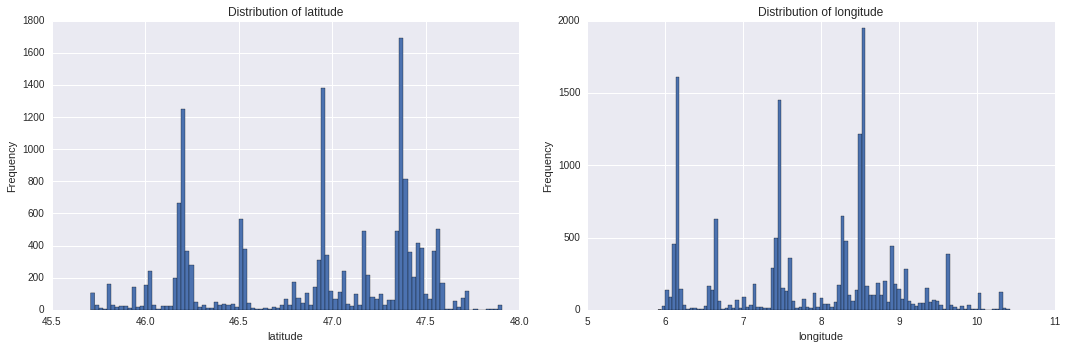

In [12]:
# keep coordinates
coordinates = data[['latitude', 'longitude']]
# plot distribution
coordinates_distribution(coordinates)

**Example for 2010:**
The coordinates distribution indicates that most tweets are from the area of approx (47.4, 8.5). We would like to point out that the coordinates for Zurich are (47.3769, 8.5417). Hence, the data reveals a known fact: Zurich is the most populated city in Switzerland.

<a name="assumption_workplace"></a>
At this point, we start making some **assumptions** in order to extract more information from the given dataset. More concretely, we try to find if a tweet is posted from the workplace or not. In order to achieve that, we use the following reasoning:
* Tweet from workplace: the day of tweet should be between Monday and Friday and in the time slot between 08:00 and 18:00
* Tweet not from workplace: everything else that is not in the aforementioned time slot

In [13]:
# is the tweet posted at work or not
data['atWork'] = data.apply(lambda row: is_at_work(row['createdAt']), axis=1)
# get hour of tweet
data['hourOfTweet'] = data['createdAt'].dt.hour
data.head()

,tweetId,userId,createdAt,longitude,latitude,atWork,hourOfTweet
1,9514846412,7198282,2010-02-23 06:22:40,8.53781,47.3678,False,6
2,9516574359,14657884,2010-02-23 07:34:25,6.13396,46.1951,False,7
7,9519149278,14260616,2010-02-23 09:32:09,8.29953,47.4829,True,9
8,9519737890,14657884,2010-02-23 09:59:41,6.13870,46.1750,True,9
10,9521789689,9962022,2010-02-23 11:28:27,6.33641,46.4631,True,11


At this point, we materialize our new dataframe, so that it can be used for other parts of the project, if necessary.

In [14]:
# set file_name
file_name = '../../data/processed_tweets_' + year + '.csv'
if not os.path.exists(file_name):
    data.set_index('tweetId').to_csv(path_or_buf=file_name, sep='|')
else:
    data = pd.read_csv(file_name, sep='|')

We can visualize how many tweets are posted from the workplace and how many from somewhere else.

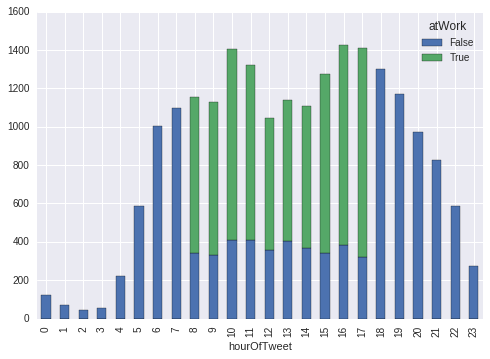

In [15]:
tweet_count = pd.crosstab(index=data['hourOfTweet'], columns=data['atWork'])
tweet_count.plot(kind='bar', stacked='True')
plt.show()

The figure reveals that people tend to use Twitter quiet a lot while working (under the assumption described [earlier](#assumption_workplace)). Moreover, the figure reveals the time slots in which people tend to tweet the most.

Now, we create a dataframe that contains only data about the active users.

In [16]:
active_users_data = data

## Mobilty Patterns

In order to study mobility patters, we need to find the users home location. Having that information, we try to estimate 
* the time and distance needed to go to work
* the radius of gyration (defined later) for every user

We start by determing the home location of each user. In order to do that, the make the following **assumptions**:
* the tweet should not have been sent during working hours.
* the most frequent location is most probably the house location.

<a name="assumption_home_location"></a>

### Determining Home Locations
1. For each active user, we keep the tweets that are sent in time slots besides the working hours.
2. We reduce the location accuracy to 780 meters, for both latitude and longitude. This is done by keeping only 2 decimals in the GPS coordinates. More details about the GPS accuracy can be found [here](https://en.wikipedia.org/wiki/Decimal_degrees).
3. We count the tweets per location.
4. We set the house location to be the location with the most number of tweets.

We start by building a dataframe that contains information about users not beeing at work.

In [17]:
active_users_at_home = active_users_data[~active_users_data['atWork']]

We reduce the accuracy location of the GPS coordinates.

In [18]:
# define accuracy
accuracy = 2
# initialize column with reduced accuracy
active_users_at_home['reducedAccuracy'] = np.nan
# fill values for the new column
active_users_at_home = active_users_at_home.apply(lambda row: reduce_location_accuracy(row, accuracy), axis=1)
# display result
active_users_at_home.head()

,tweetId,userId,createdAt,longitude,latitude,atWork,hourOfTweet,reducedAccuracy
0,9514097914,17341045,2010-02-23 05:55:51,7.43926,46.9489,False,5,"(46.95, 7.44)"
1,9514846412,7198282,2010-02-23 06:22:40,8.53781,47.3678,False,6,"(47.37, 8.54)"
2,9516574359,14657884,2010-02-23 07:34:25,6.13396,46.1951,False,7,"(46.20, 6.13)"
12,9536575795,14260616,2010-02-23 18:19:03,8.26010,47.4576,False,18,"(47.46, 8.26)"
13,9537030723,14542024,2010-02-23 18:31:46,8.51865,47.3703,False,18,"(47.37, 8.52)"


Now, we find the home location according to the [assumptions](#assumption_home_location) we made.

In [19]:
# get coordinated of the most frequent location that is considered to be the user's home
home_locations = most_freq_locations(active_users_at_home)
# initialize columns
home_locations['frequentLatitude'] = 0.0
home_locations['frequentLongitude'] = 0.0
# extract latitude and longitude from coordinates tuple
home_locations = home_locations.apply(lambda row: get_freq_loc_coordinates(row), axis=1)
# remove unnecessary column
home_locations.drop('frequentLocation', inplace=True, axis=1)
# display information
home_locations.head()

,numTweets,frequentLatitude,frequentLongitude
userId,,,
18123,12,47.46,8.33
41483,13,46.20,6.16
51233,61,45.60,10.23
53453,27,47.00,6.94
99983,9,47.50,8.73


We keep only users that have more than 5 tweets from the location that is considered to be the house of each user. This filtering helps in further removing noise from the data. Also, it increases our certainty that the determined location is indeed the user's house location. Again, the value (threshold = 5) is selected empirically. 

In [20]:
# keep only users that tweeted more than 5 times from the place that is considered to be the user's house
home_locations = home_locations[home_locations['numTweets'] >= 5]

### Determining Workplace Locations
1. For each active user, we keep the tweets that are sent in time slots of working hours.
2. We reduce the location accuracy to 780 meters, for both latitude and longitude. This is done by keeping only 2 decimals in the GPS coordinates.
3. We count the tweets per location.
4. We set the workplace location to be the location with the most number of tweets.

We start by building a dataframe that contains information about users beeing at work.

In [21]:
active_users_at_work = active_users_data[active_users_data['atWork']]

The rest of the procedure is exactly the same as the one followed for determining the house locations.

In [22]:
# define accuracy
accuracy = 2
# initialize column with reduced accuracy
active_users_at_work['reducedAccuracy'] = np.nan
# fill values for the new column
active_users_at_work = active_users_at_work.apply(lambda row: reduce_location_accuracy(row, accuracy), axis=1)
# display result
active_users_at_work.head()

,tweetId,userId,createdAt,longitude,latitude,atWork,hourOfTweet,reducedAccuracy
3,9517198943,14393717,2010-02-23 08:02:57,6.63254,46.5199,True,8,"(46.52, 6.63)"
4,9517916537,13535402,2010-02-23 08:35:39,8.53010,47.3152,True,8,"(47.32, 8.53)"
5,9518014755,14393717,2010-02-23 08:40:13,6.63428,46.5191,True,8,"(46.52, 6.63)"
6,9519149278,14260616,2010-02-23 09:32:09,8.29953,47.4829,True,9,"(47.48, 8.30)"
7,9519737890,14657884,2010-02-23 09:59:41,6.13870,46.1750,True,9,"(46.17, 6.14)"


In [23]:
# get coordinated of the most frequent location that is considered to be the user's home
workplace_locations = most_freq_locations(active_users_at_work)
# initialize columns
workplace_locations['frequentLatitude'] = 0.0
workplace_locations['frequentLongitude'] = 0.0
# extract latitude and longitude from coordinates tuple
workplace_locations = workplace_locations.apply(lambda row: get_freq_loc_coordinates(row), axis=1)
# remove unnecessary column
workplace_locations.drop('frequentLocation', inplace=True, axis=1)
# display information
workplace_locations.head()

,numTweets,frequentLatitude,frequentLongitude
userId,,,
18123,5,47.46,8.33
41483,6,46.21,6.14
51233,2,45.60,10.23
53453,23,47.00,6.94
99983,17,47.44,8.56


Again, we keep only users that tweeted more than 5 times from their workplace.

In [24]:
workplace_locations = workplace_locations[workplace_locations['numTweets'] >= 5]

### Detecting Mobility Flows

Since we have determined the home and workplace locations of each user, we can start working on the mobility flows. First, we join the two dataframes that contain information about the workplace and house location and create a new dataframe with aggregated information.

In [25]:
# join dataframes with information about the house and workplace locations of each user (join using user ID)
joined = pd.merge(home_locations, workplace_locations, 
                  how='inner', left_index=True, right_index=True, suffixes=('_x', '_y'))
# set meaningful names
joined.columns = ['tweetsHome', 'homeLatitude', 'homeLongitude', 'tweetsWork', 'workLatitude', 'workLongitude']
# display result
joined.head()

,tweetsHome,homeLatitude,homeLongitude,tweetsWork,workLatitude,workLongitude
userId,,,,,,
18123,12,47.46,8.33,5,47.46,8.33
41483,13,46.20,6.16,6,46.21,6.14
53453,27,47.00,6.94,23,47.00,6.94
99983,9,47.50,8.73,17,47.44,8.56
120433,315,46.95,7.47,118,46.95,7.47


In [26]:
# show rows of dataframe
joined.shape[0]

133

It is possible, that a user's home and working place are the same (e.g for people that do not work or work from home). We remove those users since they cannot contribute to the mobility patterns we are trying to study.

In [27]:
# remove users whose home and work locations are the same
joined = joined[~((joined['homeLatitude'] == joined['workLatitude']) & 
                  (joined['homeLongitude'] == joined['workLongitude']))]
# print number of rows
joined.shape[0]

79

We materialize the <code>joined</code> dataframe.

In [28]:
# define file name
file_name = '../../data/joined_' + year + '.csv'
if not os.path.isfile(file_name):
    # save file if it does not exist
    joined.to_csv(file_name, sep='|')
else:
    # load file if it exists
    joined = pd.read_csv(file_name, sep='|', index_col=[0])

## Visualizing Results

We visualize the results of the mobility patterns.

In [29]:
# keep user IDs
user_ids = joined.index.values.tolist()

In [30]:
# keep coordinates of workplace
workplace_coord = list(zip(joined['workLatitude'].values, joined['workLongitude'].values))
# keep coordinates of home
homeplace_coord = list(zip(joined['homeLatitude'].values, joined['homeLongitude'].values))

We create a map that displays the **workplaces and homeplaces in blue and red colors** respectively. By clicking on each bullet, you can see the user ID.

In [31]:
# create swiss map
swiss_map = create_swiss_map(year, workplace_coord, homeplace_coord, user_ids)
# plot map
swiss_map

Some users work far away from their home. Therefore, we created a visualization tool that displays the home and workplace for a particular user given his user ID.

In [32]:
# example for 2010
swiss_map = create_swiss_map(year, workplace_coord, homeplace_coord, user_ids, show_all_users=False, user_id=16145458)
swiss_map

# # example for 2011
# swiss_map = create_swiss_map(year, workplace_coord, homeplace_coord, user_ids, show_all_users=False, user_id=10933802)
# swiss_map

## Travel Information

We use the <code>googlemaps</code> API to get information about the route of each user. This information regards
* distance to work in km (using the road network and not a straight line)
* time to work

Moreover, we use the same API to get the canton of the workplace and residence. This helps in further studying the mobility flows.

In [33]:
# read key from file
with open('key.txt', 'r') as input_file:
    KEY = input_file.read().rstrip()
# initialize googlemaps object
gmaps = googlemaps.Client(key=KEY)

In [34]:
# initialize columns
joined['distance'] = np.nan
joined['time'] = np.nan
joined['homeCanton'] = np.nan
joined['workCanton'] = np.nan
# print number of rows
joined.shape[0]

79

In [35]:
# load swiss cantons
json_data = pd.read_json('../../data/maps/ch-cantons.topojson.json', typ='dataframe')
swiss_cantons = [item['id'] for item in json_data['objects']['cantons']['geometries']]

In [36]:
file_name = '../../data/travel_info_' + year + '.csv'
# if file does not exist, save data to file
if not os.path.isfile(file_name):
    # get travel info
    print('Getting travel information...')
    joined = joined.apply(lambda row: get_travel_info(row, gmaps, debug=True), axis=1)
    joined['distance'] = joined['distance'] / 1000.0
    joined['time'] = joined['time'] / 60.0
    # materialize view
    joined.to_csv(file_name, sep='|')
    
    # get canton of residence and workplace
    print('Getting canton information...')
    joined = joined.apply(lambda row: find_cantons(row, gmaps, debug=True), axis=1)
    # check if home or work is in switzerland
    joined = joined[(joined['homeCanton'].isin(swiss_cantons)) | (joined['workCanton'].isin(swiss_cantons))]
    joined.to_csv(file_name, sep='|')
    travel_data = joined
# load data from file
else:
    travel_data = pd.read_csv(file_name, sep='|', index_col='userId')

We check if the <code>travel_data</code> dataframe has NaN values (may be possible due to <code>googlemaps</code> API).

In [37]:
# rows before dropping NaN, if any exist
print('Rows before filtering: ', travel_data.shape[0])
print('Containts NaN values: ', travel_data.isnull().values.any())
travel_data.dropna(inplace=True)
# rows after dropping NaN, if any exist
print('Rows after filtering: ',travel_data.shape[0])

Rows before filtering:  74
Containts NaN values:  False
Rows after filtering:  74


#### Where people live and where they work

Here, we show a plot that reveals where people live and where they work. In some cases (e.g. 2011), we see that some people work in Switzerland but live in other areas. In order to create a clear plot, we set a **threshold** for the minimum number of people that work and live in each canton tuple.

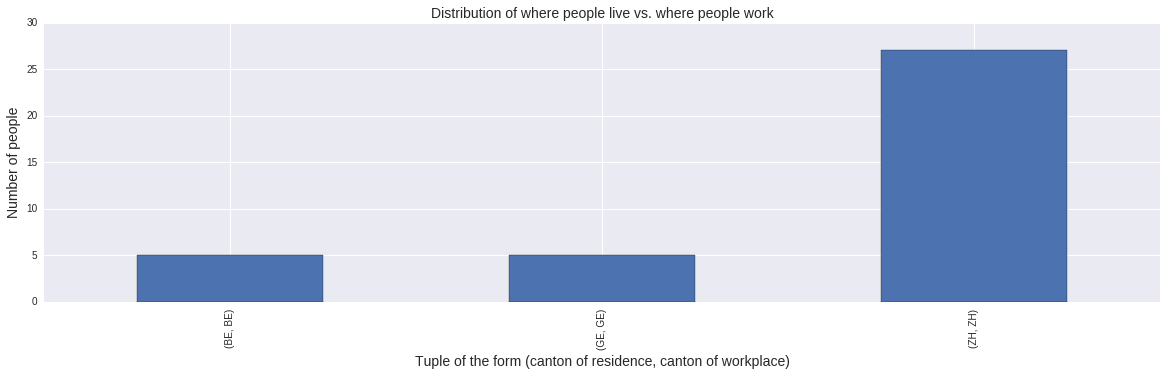

In [38]:
# threshold value
threshold = 5
# groub by home and workplace cantons
travel_data_grouped = travel_data.groupby(by=['homeCanton', 'workCanton']).size()
ax = travel_data_grouped[travel_data_grouped >= threshold].plot(kind='bar', figsize=(20, 5))
# set display information
ax.set_xlabel('Tuple of the form (canton of residence, canton of workplace)', fontsize=14)
ax.set_ylabel('Number of people', fontsize=14)
ax.set_title('Distribution of where people live vs. where people work', fontsize=14)
plt.show()

### Time and Distance to Work

Also, we plot the distribution of the total distance and time needed for the users to reach their workplace.

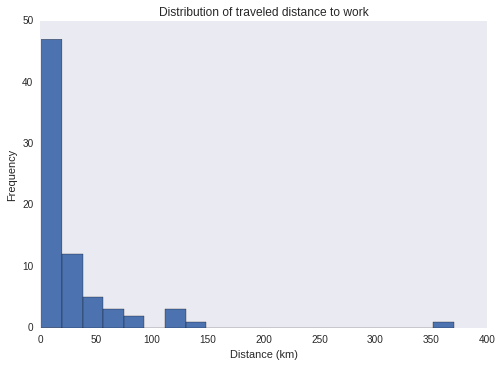

In [39]:
# plot distance distribution
plt.hist(travel_data['distance'], bins=20)
# set display info
plt.title('Distribution of traveled distance to work')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

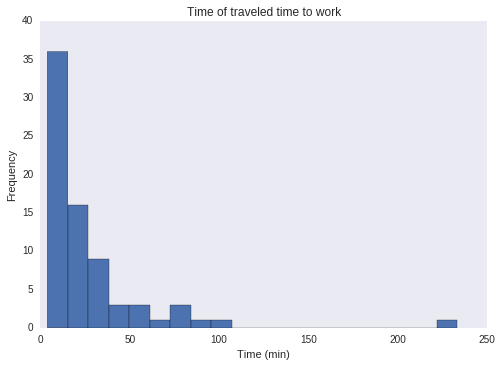

In [40]:
# plot time distribution
plt.hist(travel_data['time'], bins=20)
# set display info
plt.title('Time of traveled time to work')
plt.xlabel('Time (min)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

Finally, we give the median distance and time to work:

In [41]:
print('The median distance is: {0:.2f} km'.format(np.median(travel_data['distance'])))
print('The median time is: {0:.2f} minutes'.format(np.median(travel_data['time'])))

The median distance is: 6.72 km
The median time is: 16.48 minutes


## Radius of Gyration

The radius of gyration is the standard deviation of distances between tweets and the user’s likely home location and is estimated for each user [[2]](#refs). A low radius of gyration indicates that a user travels in shorter distances, while a high radius of gyration exhibits users with longer distance trips.

The radius of gyration for each user is given by $$r_g = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(r_i - r_h)^2}$$
where
* $n$ : the number of tweets
* $r_i$ : the location of the tweet i
* $r_h$ : the home location

We start by joining the <code>travel_data</code> dataframe, that contains the home location for each user, with the initial <code>data</code> dataframe, that contains information from the Twitter dataset. The join operation creates a new dataframe that contains both the home location and the location of every other tweet for each user. This is crucial in order to apply the aforementioned formula.

In [42]:
# join using the user ID
location_info = pd.merge(travel_data[['homeLatitude', 'homeLongitude']], data, 
                         how='inner', left_index=True, right_on='userId')
# remove unnecessary columns
location_info.drop(['createdAt', 'atWork', 'hourOfTweet'], inplace=True, axis=1)
# display information
location_info.head()

,homeLatitude,homeLongitude,tweetId,userId,longitude,latitude
362,46.2,6.16,10113527390,41483,6.15593,46.2046
487,46.2,6.16,10283521102,41483,6.15685,46.2044
523,46.2,6.16,10340297205,41483,6.14474,46.2117
603,46.2,6.16,10446783265,41483,6.15694,46.2042
676,46.2,6.16,10536246475,41483,6.15689,46.2043


In order to estimate the gyration, the first thing to do is to find the square euclidean distance between the home location and other locations for each user.

In [43]:
# find the distance between each
location_info['distanceFromHome'] = (location_info['homeLatitude'] - location_info['latitude']
                                    ) + (location_info['homeLongitude'] - location_info['longitude'])
location_info['distanceFromHome'] = location_info['distanceFromHome'].pow(2)
location_info.head()

,homeLatitude,homeLongitude,tweetId,userId,longitude,latitude,distanceFromHome
362,46.2,6.16,10113527390,41483,6.15593,46.2046,2.809000e-07
487,46.2,6.16,10283521102,41483,6.15685,46.2044,1.562500e-06
523,46.2,6.16,10340297205,41483,6.14474,46.2117,1.267360e-05
603,46.2,6.16,10446783265,41483,6.15694,46.2042,1.299600e-06
676,46.2,6.16,10536246475,41483,6.15689,46.2043,1.416100e-06


Also, we define a lambda function that helps in determining the gyration of each user. This function performs the following operations of the aforementioned gyratio equation:
1. the sum of squares 
2. divides with the number of tweets per user 
3. takes the square root of the result

In [44]:
estimate_gyration = lambda df: np.sqrt(1/df.size * df.sum())

In [45]:
# apply the estimate_gyration function to each one of the sub-dataframes created by the groupby operation
gyration = location_info.groupby(by='userId')['distanceFromHome'].transform(estimate_gyration)
# keep tweets per user
tweets_per_user = location_info.groupby(by='userId').size()
# give meaniningful column name
gyration.columns = ['gyration']

The gyration radius is given in degrees. However, a gyration radius given in kilometers would reveal mobility information about each user. Hence, the radius of gyration is converted to kilometers. According to the [Latitude/Longitude Distance Calculator](http://www.nhc.noaa.gov/gccalc.shtml), 1 degree equals to 111km.

In [46]:
# convert radius of gyration from degrees to kilometers
location_info['gyration'] = gyration * 111
# remove redundant columns
gyration_info = location_info.drop(['longitude', 'latitude', 'distanceFromHome', 'tweetId'], axis=1)
# drop duplicate rows
gyration_info.drop_duplicates(subset='userId', inplace=True)
# set user ID as index
gyration_info.set_index('userId', inplace=True)
# append tweets per user
gyration_info['tweets'] = tweets_per_user
# set file name for saving
file_name = '../../data/gyration_' + year + '.csv'
gyration_info.to_csv(path_or_buf=file_name, sep='|')
# display information
gyration_info.head()

,homeLatitude,homeLongitude,gyration,tweets
userId,,,,
41483,46.20,6.16,6.002368,54
99983,47.50,8.73,20.044392,58
626163,46.17,9.00,23.202860,350
634553,46.20,6.20,67.930450,386
640043,45.79,9.37,23.157559,70


### Visualizing Radius of Gyration

Now, we plot the distribution of the radius of gyration. This distribution gives a rough estimate of how much Swiss people travel. However, we have to point out that this **estimation depends on the given dataset**, i.e. we cannot drow any general conclusions that the majority of Swiss does not travel a lot. 

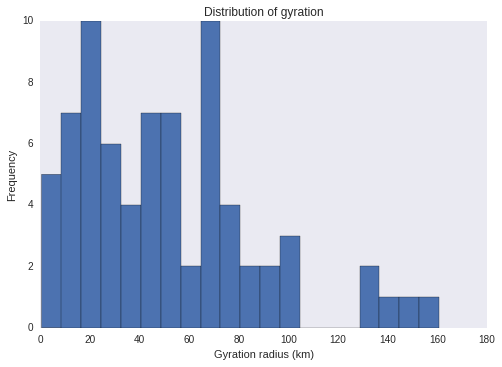

In [47]:
plt.hist(gyration_info['gyration'], bins=20)
plt.title('Distribution of gyration')
plt.xlabel('Gyration radius (km)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

Finally, we visualize the gyration radius of a subset of the users.

In [48]:
# keep users with a gyration radius smaller than 40km
short_distance = gyration_info.drop('tweets', axis=1)[gyration_info['gyration'] <= 40]
# how many users compared to the whole dataset travel less than 40 km
print('{0:.2f}'.format(float(short_distance.shape[0]) / gyration_info.shape[0] * 100) + '%')

41.89%


In [49]:
swiss_map = visualize_gyration_radius(short_distance, year)
swiss_map

## References
<a name="refs"></a>
1. N. Swier, B. Komarniczky and B. Clapperton. *Using geolocated Twitter traces to infer residence and mobility*. GSS Methodology Series No 41, October 2015
2. Abdullah Kurkcu. *Evaluating the Usability of Geolocated Twitter as a Tool for Human Activity and Mobility Patterns: A Case Stude for NYC*. October 2015